## Artificial vortex array flow test

## Averaged flows


In [69]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
import pickle 
import os
import sys
import pandas as pd
from scipy.ndimage import rotate, gaussian_filter
import pickle 
import bz2

sys.path.append('../vasco_scripts')  # add the relative path to the folder
from defects import *  # import the module from the folder

def divergence_npgrad(flow):
    flow = np.swapaxes(flow, 0, 1)
    Fx, Fy = flow[:, :, 0], flow[:, :, 1]
    dFx_dx = np.gradient(Fx, axis=0)
    dFy_dy = np.gradient(Fy, axis=1)
    return (dFx_dx + dFy_dy).T

def curl_npgrad(flow):
    flow = np.swapaxes(flow, 0, 1)
    Fx, Fy = flow[:, :, 0], flow[:, :, 1]
    dFx_dy = np.gradient(Fx, axis=1)
    dFy_dx = np.gradient(Fy, axis=0)
    curl = dFy_dx - dFx_dy
    return curl.T

def analyze_defects(img, sigma=15):
    # Calculate mgrid
    yy, xx = np.mgrid[0:img.shape[0], 0:img.shape[1]]
    
    # Calculate orientation analysis
    ori, coh, E = orientation_analysis(img, sigma)
    
    # Compute topological charges
    k = compute_topological_charges(-ori, int_area='cell', origin='lower')
    
    # Localize defects
    defects = localize_defects(k, x_grid=xx, y_grid=yy)
    
    # Compute defect orientation
    compute_defect_orientations(-ori, defects, method='interpolation', x_grid=xx[0,:], y_grid=yy[:,0], interpolation_radius=5, min_sep=1)
    
    # Filter defects by charge
    plushalf = defects[defects['charge']==.5]
    minushalf = defects[defects['charge']==-.5]
    
    return ori, plushalf, minushalf

%matplotlib qt

import sys,time,random
def progressBar(count_value, total, suffix=''):
    bar_length = 100
    filled_up_Length = int(round(bar_length* count_value / float(total)))
    percentage = round(100.0 * count_value/float(total),1)
    bar = '=' * filled_up_Length + '-' * (bar_length - filled_up_Length)
    sys.stdout.write('[%s] %s%s ...%s\r' %(bar, percentage, '%', suffix))
    sys.stdout.flush()

save_folder = r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\Images"


image_list = glob.glob(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\*.tif")
image_list = natsorted(image_list, key=lambda y: y.lower())

### Test flow parameters
`flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)`

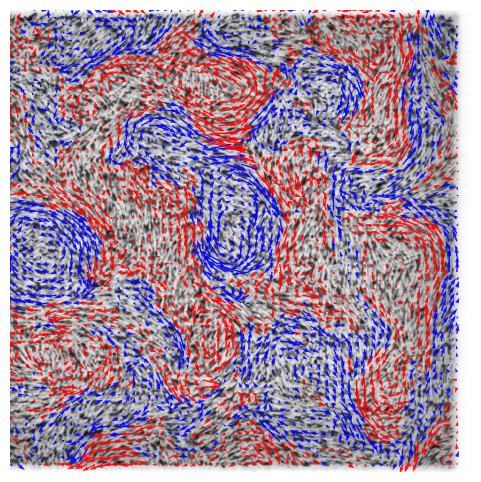

In [143]:
%matplotlib inline
SAVE = True

im_num = 100

img1 = cv2.imread(image_list[im_num])[:,900:,0]
img2 = cv2.imread(image_list[im_num+1])[:,900:,0]
flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
    winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0) 

step = 15
fig, ax1 = plt.subplots(1,1,  figsize=(6,6))
extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
ax1.axis('off')    
# ax1.imshow(img1, cmap="gray")
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)
ax1.imshow(255-img_clahe, cmap="gray")  

if SAVE:
    fig.savefig(save_folder + "/raw.svg", bbox_inches=extent.expanded(1.15, 1.15))                                     

field = np.stack((flow[:,:,0], flow[:,:,1]), axis=-1)
vorticity = gaussian_filter(curl_npgrad(field), sigma=15).T
# c = ax1.imshow(vorticity, cmap='RdBu', alpha=.3)
# fig.colorbar(c, ax=ax1)

vort_min = 0.005
vortTFr = vorticity > vort_min
vortTFl = vorticity < vort_min
ur = flow[:,:,0] * vortTFr
vr = flow[:,:,1] * vortTFr
ul = flow[:,:,0] * vortTFl
vl = flow[:,:,1] * vortTFl

y, x = np.mgrid[0:img1.shape[0], 0:img1.shape[1]]
# ax1.quiver(x[::step, ::step], y[::step, ::step], 
#         flow[::step, ::step, 0], -flow[::step, ::step, 1], 
#         color="red", scale=120, alpha=.9, width=.003)

ax1.quiver(x[::step, ::step], y[::step, ::step], 
        ur[::step, ::step], -vr[::step, ::step], 
        color="b", scale=120, alpha=.9, width=.003, minlength=0)
ax1.quiver(x[::step, ::step], y[::step, ::step], 
        ul[::step, ::step], -vl[::step, ::step], 
        color="r", scale=120, alpha=.9, width=.003, minlength=0)           
        

# speed = np.sqrt(flow[:,:,0]**2 + flow[:,:,0]**2)
# lw = 3*speed / speed.max()
# ax1.streamplot(x[::step, ::step],y[::step, ::step],
#         flow[::step, ::step, 0], flow[::step, ::step, 1], 
#         density=4., color='white', linewidth=lw[::step, ::step])

if SAVE:
    fig.savefig(save_folder + "/flow_field.svg", bbox_inches=extent.expanded(1.15, 1.15))



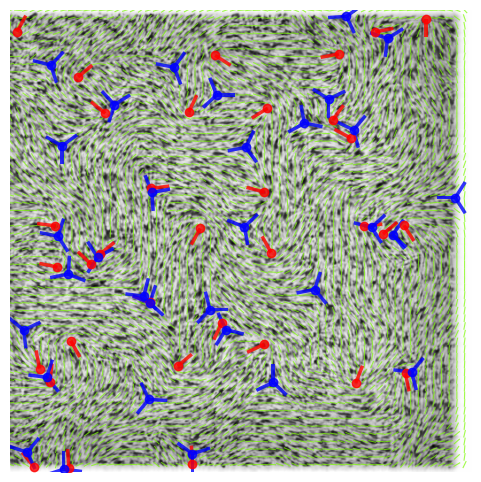

In [154]:
%matplotlib inline

ori, plushalf, minushalf = analyze_defects(img1, sigma=11)

step = 15
fig, ax1 = plt.subplots(1,1,  figsize=(6,6))
extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
ax1.axis('off')   

ax1.imshow(255-img_clahe, cmap="gray")

s = 15
# x = np.arange(0, img1.shape[1], s)
# y = np.arange(0, img1.shape[0], s)
y, x = np.mgrid[0:img1.shape[0], 0:img1.shape[1]]

ax1.quiver(x[::s,::s], y[::s,::s],
    np.cos(ori)[::s,::s], np.sin(ori)[::s,::s], 
    headaxislength=0, headwidth=0, headlength=0, 
    color='lawngreen', scale=60, pivot='mid', alpha=.7)

alpha_half, scale_half = .8, 25    
ax1.plot(plushalf['x'], plushalf['y'],'ro',markersize=6, alpha=alpha_half)
ax1.quiver(plushalf['x'], plushalf['y'], 
    np.cos(plushalf['ang1']), -np.sin(plushalf['ang1']), 
    headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

ax1.plot(minushalf['x'], minushalf['y'],'bo',markersize=6, alpha=alpha_half)
for j in range(3):
    ax1.quiver(minushalf['x'], minushalf['y'], 
        np.cos(minushalf['ang'+str(j+1)]), -np.sin(minushalf['ang'+str(j+1)]), 
        headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)
        
if SAVE:
    fig.savefig(save_folder + "/director_field1.svg", bbox_inches=extent.expanded(1.15, 1.15))


In [174]:
u = []
v = []

for (i,im1), im2 in zip(enumerate(image_list[:-1]), image_list[1:]):
    #right image [:,900:,0] / left image [:,:900,0]
    img1 = cv2.imread(im1)[:,900:,0]
    img2 = cv2.imread(im2)[:,900:,0]
    flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    u.append(flow[..., 0])
    v.append(flow[..., 1])

    # if i>10:
    #     break

    progressBar(i, len(image_list))

# with open(save_folder + "/flow.pkl", 'wb') as f:
#     pickle.dump(dict(u=u, v=v), f)

In [214]:
energy_list = [((uu**2+vv**2)/2.) for (uu,vv) in zip(u,v)]
energy_av_std = np.array([(np.mean(e), np.std(e)) for e in energy_list])

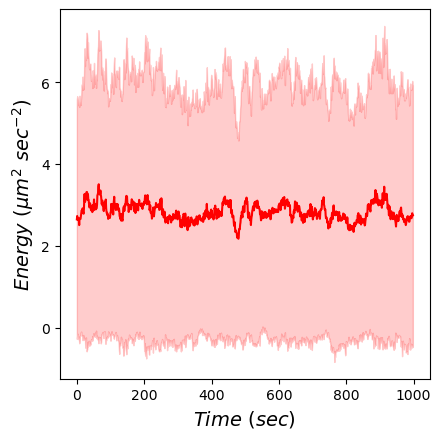

In [274]:
plt.plot(np.arange(len(energy_av_std[:,0])), energy_av_std[:,0], "r")
plt.fill_between(np.arange(len(energy_av_std)),
    energy_av_std[:,0] - energy_av_std[:,1], energy_av_std[:,0] + energy_av_std[:,1],
    color="r", alpha=.2)  
plt.xlabel(r"$Time ~(sec)$", fontsize=14)
plt.ylabel(r"$Energy ~(\mu m^2 ~sec^{-2})$", fontsize=14)
plt.gca().set_box_aspect(1)
 

In [261]:
enstrophy_list = [(np.gradient(vv)[1] - np.gradient(uu)[0])**2/2. for (uu,vv) in zip(u,v)]
enstropy_av_std = np.array([(np.mean(e), np.std(e)) for e in enstrophy_list])

# [u_x,u_y] = np.gradient(px_size * uf,dx);
# %         [v_x,v_y] = gradient(px_size * vf,dx);
# %         enstrophy(k,i) = mean2(0.5*(v_x - u_y).^2);

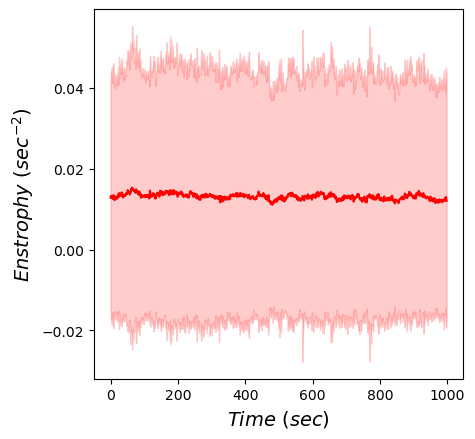

In [273]:
plt.plot(np.arange(len(enstropy_av_std[:,0])), enstropy_av_std[:,0], "r")
plt.fill_between(np.arange(len(enstropy_av_std)),
    enstropy_av_std[:,0] - enstropy_av_std[:,1], enstropy_av_std[:,0] + enstropy_av_std[:,1],
    color="r", alpha=.2)   
plt.xlabel(r"$Time ~(sec)$", fontsize=14)
plt.ylabel(r"$Enstrophy ~(sec^{-2})$", fontsize=14)       
plt.gca().set_box_aspect(1)

Text(0, 0.5, '$Enstrophy ~(sec^{-2})$')

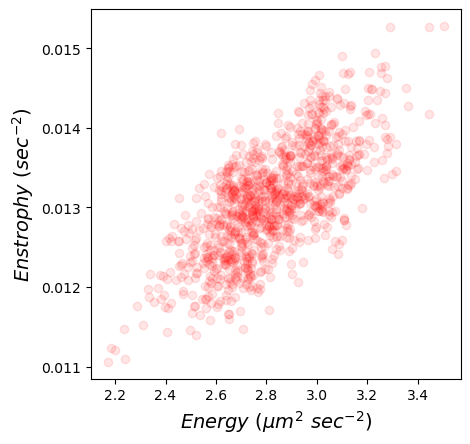

In [275]:
%matplotlib inline
plt.plot(energy_av_std[:,0], enstropy_av_std[:,0], "or", alpha=.1)
plt.gca().set_box_aspect(1)
plt.xlabel(r"$Energy ~(\mu m^2 ~sec^{-2})$", fontsize=14)
plt.ylabel(r"$Enstrophy ~(sec^{-2})$", fontsize=14)

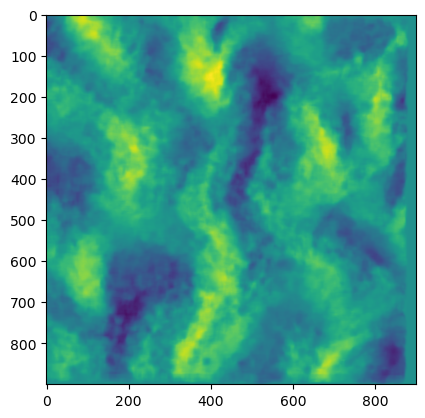

In [173]:
plt.imshow(np.mean(v, axis=0))

# Start Here Find Pairs

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from scipy.ndimage import gaussian_filter
from scipy import spatial
from sklearn.neighbors import KDTree
from scipy.stats import circmean, circstd, sem
import os
import sys
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import sys,time,random

def progressBar(count_value, total, suffix=''):
    bar_length = 100
    filled_up_Length = int(round(bar_length* count_value / float(total)))
    percentage = round(100.0 * count_value/float(total),1)
    bar = '=' * filled_up_Length + '-' * (bar_length - filled_up_Length)
    sys.stdout.write('[%s] %s%s ...%s\r' %(bar, percentage, '%', suffix))
    sys.stdout.flush()

def roll_func(what,basis,window,func,*args,**kwargs):
    '''https://stackoverflow.com/questions/14300768/pandas-rolling-computation-with-window-based-on-values-instead-of-counts'''
    
    '''see more examples:
    https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-python-numpy-scipy/14314054#14314054'''
    # from scipy.stats import circmean, circstd
    #note that basis must be sorted in order for this to work properly     
    indexed_what = pd.Series(what.values,index=basis.values)
    def applyToWindow(val):
        # using slice_indexer rather that what.loc [val:val+window] allows
        # window limits that are not specifically in the index
        indexer = indexed_what.index.slice_indexer(val-window,val+window,1)
        chunk = indexed_what.iloc[indexer]
        return func(chunk,*args,**kwargs)
    rolled = basis.apply(applyToWindow)
    return rolled

def plot_rolling_average(df,ax, what_key, basis_key, show=True, win=15, color="red", avfunc=circmean, stdfunc=circstd, *args,**kwargs):
    df = df.sort_values(by=basis_key)
    df[what_key+"_ave"] = roll_func(df[what_key], df[basis_key], win, avfunc, *args,**kwargs)*180/np.pi
    df[what_key+"_std"] = roll_func(df[what_key], df[basis_key], win, stdfunc)*180/np.pi
    df[what_key+"_count"] = roll_func(1.*df[what_key].abs(), df[basis_key], win, np.sum)
    if show:
        ax.plot(df.distance, df[what_key+"_ave"], "-", color=color, alpha=.6, linewidth=3)
        ax.fill_between(df[basis_key], 
                        df[what_key+"_ave"]-df[what_key+"_std"]/df[what_key+"_count"]**.5, 
                        df[what_key+"_ave"]+df[what_key+"_std"]/df[what_key+"_count"]**.5, 
                        color=color, alpha=.2) 
    return df[[basis_key, what_key+"_ave", what_key+"_std", what_key+"_count"]] 


def msd_from_df(df,xlabel,ylabel,tlabel,id_label,minimal_track=3):
    def msd(x,y):
        return np.cumsum(np.diff(x))**2 + np.cumsum(np.diff(y))**2

    msds = []
    for id in df[id_label].unique():
        idx = (df[id_label]==id)
        if idx.sum()>minimal_track:
            t = df[tlabel][idx].to_numpy()
            t = t[1:]-t[0]
            x = df[xlabel][idx].to_numpy()
            y = df[ylabel][idx].to_numpy()
            msds.append(pd.DataFrame({"FRAME": t, 'MSD':msd(x,y)}).dropna())            
    return pd.concat(msds)    

def ang_msd_from_df(df,xlabel,tlabel,id_label,period=2*np.pi, minimal_track=3):
    def msd(x):
        x = np.unwrap(x, period=period)
        return np.cumsum(np.diff(x))**2

    msds = []
    for id in df[id_label].unique():
        idx = (df[id_label]==id)
        if idx.sum()>minimal_track:
            t = df[tlabel][idx].to_numpy()
            t = t[1:]-t[0]
            x = df[xlabel][idx].to_numpy()
            msds.append(pd.DataFrame({"FRAME": t, 'MSD':msd(x)}).dropna())            
    return pd.concat(msds)

plus_minus_df = pd.read_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects/PlusAndMinusTM.csv")
plus_minus_df.head()

,Unnamed: 0,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,...,CONTRAST_CH1,SNR_CH1,x_img,y_img,x_img1,y_img1,ang1,ang2,ang3,charge
0,0,ID278212,278212,0.0,81.421532,552.0,478.0,0.0,0.0,0,...,0.973672,1.625018,733.764838,268.454037,734.0,269.0,0.942478,NaN,NaN,0.5
1,1,ID278213,278213,1.0,81.421532,531.0,508.0,0.0,0.0,0,...,0.973672,1.625018,703.283614,224.629008,703.0,225.0,0.314159,NaN,NaN,0.5
2,2,ID278214,278214,2.0,81.421524,185.0,517.0,0.0,0.0,0,...,0.973672,1.625018,201.069153,211.481499,201.0,212.0,-1.005310,NaN,NaN,0.5
3,3,ID278215,278215,3.0,81.421524,274.0,524.0,0.0,0.0,0,...,0.973672,1.625018,330.251486,201.255659,330.0,202.0,-1.507964,NaN,NaN,0.5
4,4,ID278208,278208,NaN,68.126724,90.0,380.0,0.0,0.0,0,...,0.923249,1.053494,63.177900,411.615798,62.0,411.0,1.696460,NaN,NaN,0.5


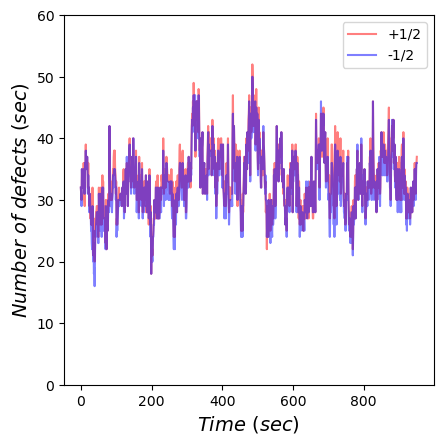

In [2]:
charge_p = []
charge_n = []
for frame in plus_minus_df.FRAME.unique():
    charge_p.append(plus_minus_df.charge[(plus_minus_df.charge==.5)&(plus_minus_df.FRAME==frame)].sum())
    charge_n.append(plus_minus_df.charge[~(plus_minus_df.charge==.5)&(plus_minus_df.FRAME==frame)].sum())

charge_p = np.array(charge_p)
charge_n = np.array(charge_n)
plt.plot(plus_minus_df.FRAME.unique(), 2*charge_p, "-r", alpha=.5, label=r"+1/2")
plt.plot(plus_minus_df.FRAME.unique(), 2*np.abs(charge_n), "-b", alpha=.5, label=r"-1/2")

plt.ylim([0,60])
# plt.title(r"$Absolute ~Charge ~of ~\pm 1/2 ~defects$", fontsize=14)
plt.xlabel(r"$Time ~(sec)$", fontsize=14)
plt.ylabel(r"$Number ~of ~defects ~(sec)$", fontsize=14)
plt.legend()
plt.gca().set_box_aspect(1)
        

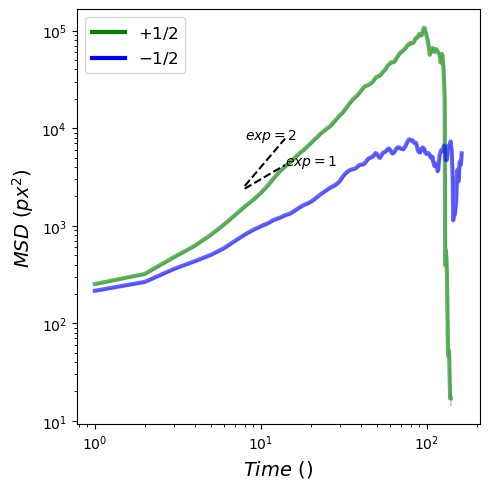

In [3]:
msd_plus_df = msd_from_df(plus_minus_df[plus_minus_df.charge==.5],"x_img1","x_img1","FRAME","TRACK_ID")
msd_minus_df = msd_from_df(plus_minus_df[plus_minus_df.charge==-.5],"x_img1","x_img1","FRAME","TRACK_ID")

%matplotlib inline
fig, ax2 = plt.subplots(1,1, figsize=(5,5))
# msd_plus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="b", alpha=.05)
# msd_minus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="g", alpha=.05)

win = 1

for msd_df,color in zip([msd_plus_df, msd_minus_df], ["g","b"]):

    msd_df = msd_df.sort_values(by="FRAME")
    msd_df["ave"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.mean)
    msd_df["std"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.std)
    msd_df["count"] = roll_func(msd_df.MSD, msd_df.FRAME, win, np.sum)

    ax2.plot(msd_df.FRAME, msd_df["ave"], "-", color=color, alpha=.6, linewidth=3)
    ax2.fill_between(msd_df.FRAME, 
                    msd_df["ave"]-msd_df["std"]/msd_df["count"]**.5, 
                    msd_df["ave"]+msd_df["std"]/msd_df["count"]**.5, 
                    color=color, alpha=.2) 


ax2.plot([0,0],[0,0], "-", color="g", linewidth=3, label=r"$+1/2$")
ax2.plot([0,0],[0,0], "-", color="b", linewidth=3, label=r"$-1/2$")
xref = np.arange(8, 15, 1)
ax2.plot(xref, 4e1*xref**2, "--k", xref, 3e2*xref**1, "--k",)
ax2.text(xref[0], 4e1*xref[-1]**2, r"$exp=2$", )
ax2.text(xref[-1], 3e2*xref[-1]**1, r"$exp=1$")
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_xlabel(r"$Time ~()$", fontsize=14); ax2.set_ylabel(r"$MSD ~(px^2)$", fontsize=14)
plt.legend(loc='upper left', fontsize=12); plt.tight_layout()

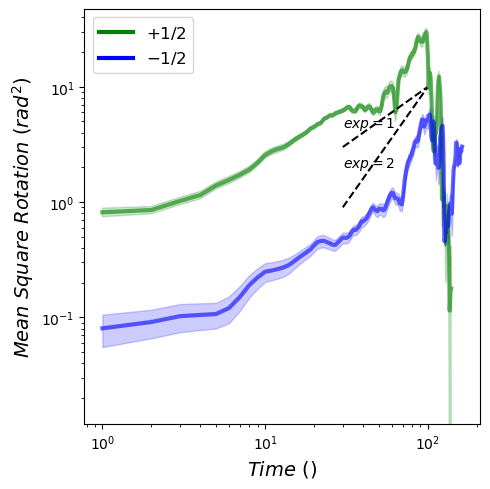

In [4]:
# plus_minus_df["angm_ave"] = circmean(plus_minus_df[["ang1","ang2","ang2"]], high=2/3*np.pi, axis=1)
plus_minus_df["angm_ave"] = plus_minus_df["ang1"] % (2/3*np.pi)
plus_minus_df1 = plus_minus_df[["ang1","angm_ave","charge","FRAME","TRACK_ID"]]

msd_plus_df = ang_msd_from_df(plus_minus_df[(plus_minus_df.charge==.5)&(plus_minus_df.FRAME>10)],
                              "ang1","FRAME","TRACK_ID", minimal_track=20)
msd_minus_df = ang_msd_from_df(plus_minus_df1[(plus_minus_df1.charge==-.5)&(plus_minus_df.FRAME>10)],
                               "angm_ave","FRAME","TRACK_ID",period=2/3*np.pi, minimal_track=20)


# msd_plus_df = msd_from_df(plus_minus_df[plus_minus_df.charge==.5],"ang1","ang1","FRAME","TRACK_ID",minimal_track=10)
# msd_minus_df = msd_from_df(plus_minus_df1[plus_minus_df1.charge==-.5],"angm_ave","angm_ave","FRAME","TRACK_ID")

%matplotlib inline
fig, ax2 = plt.subplots(1,1, figsize=(5,5))
# msd_plus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="b", alpha=.05)
# msd_minus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="g", alpha=.05)

win = 1
 
for msd_df,color in zip([msd_plus_df, msd_minus_df], ["g","b"]):

    msd_df = msd_df.sort_values(by="FRAME")
    msd_df["ave"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.mean)
    msd_df["std"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.std)
    msd_df["count"] = roll_func(msd_df.MSD, msd_df.FRAME, win, np.sum)

    ax2.plot(msd_df.FRAME, msd_df["ave"], "-", color=color, alpha=.6, linewidth=3)
    ax2.fill_between(msd_df.FRAME, 
                    msd_df["ave"]-msd_df["std"]/msd_df["count"]**.5, 
                    msd_df["ave"]+msd_df["std"]/msd_df["count"]**.5, 
                    color=color, alpha=.2) 
    # TODO check the "count" 
    # break


ax2.plot([0,0],[0,0], "-", color="g", linewidth=3, label=r"$+1/2$")
ax2.plot([0,0],[0,0], "-", color="b", linewidth=3, label=r"$-1/2$")
xref = np.arange(30, 100, 1)
ax2.plot(xref, 1e-1*xref**1, "--k", xref, 1e-3*xref**2, "--k",)
ax2.text(xref[0], 1e-1*xref[15]**1, r"$exp=1$", )
ax2.text(xref[0], 1e-3*xref[15]**2, r"$exp=2$")
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_xlabel(r"$Time ~()$", fontsize=14); ax2.set_ylabel(r"$Mean ~Square ~Rotation ~(rad^2)$", fontsize=14)
plt.legend(loc='upper left', fontsize=12); plt.tight_layout()

In [5]:
from scipy import spatial
def center_pairs(Xlong, Xshort):
    '''find indexes of Xshort in Xlong'''
    tree = spatial.KDTree(Xlong)
    return tree.query(Xshort)   

pairs = []

plus_minus_df["FRAME"].unique()[-1]
for frame in plus_minus_df["FRAME"].unique()[:]:
    # print(frame)
    p_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==.5)
    m_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==-.5)
    plus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1"]][p_idx]
    minus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1","ang2","ang3"]][m_idx]

    dist, idx = center_pairs(minus_xy[["x_img1","y_img1"]], plus_xy[["x_img1","y_img1"]])
    # set a distance that define that defects are a pair (50)
    dist_tresh = dist<30
    # Notice: some TRACK_IDs are nan, meaning that they are not a part from any trajectory
    pairs.append([
        minus_xy["TRACK_ID"].iloc[idx][dist_tresh].values,#.astype(np.int_), 
        plus_xy["TRACK_ID"][dist_tresh].values,#.astype(np.intc)
        dist[dist_tresh]
        ]) 

# pairs_df = pd.DataFrame(np.concatenate(pairs, axis=1).T, columns=["minus", "plus"]).dropna().drop_duplicates()    
pairs_df = pd.DataFrame(np.concatenate(pairs, axis=1).T, columns=["minus", "plus","dist"]).dropna().drop_duplicates()
_, indices = np.unique(pairs_df["minus"], return_index=True)
pairs_df = pairs_df.iloc[indices].copy()

In [6]:
%matplotlib qt

def equlalize_trajectories(plus_minus_df, p_idx, m_idx):
    ''' makes sure that positive (p_idx) and negative (m_idx) defect trajectory are equal
    according to "FRAME" number
    if missing frame for one of them it removed with dropna()
    '''
    df1 = plus_minus_df[["TRACK_ID","FRAME","x_img1","y_img1","ang1"]][p_idx]
    df1.set_index('FRAME', inplace=True)
    df2 =  plus_minus_df[["TRACK_ID","FRAME", "x_img1","y_img1", "ang1","ang2","ang3" ]][m_idx]
    df2.set_index('FRAME', inplace=True)
    df_ = pd.concat([df1, df2], axis=1).dropna()
    return df_.set_axis(["plus_id","xp","yp","angp1", "min_id","xm","ym", "angm1","angm2","angm3"], axis=1)

minimal_track = 5
PLOT = False

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_box_aspect(1)
plt.set_cmap('plasma')
count = 0
mp_distance = []
mp_distance_fusion = []
mp_distance_creation = []
pair_stat = []
all_pairs_df = []
fusion_TF = 1
for (num,m), n in zip(enumerate(pairs_df["minus"]), pairs_df["plus"]):
    m_idx = np.logical_and(plus_minus_df["TRACK_ID"]==m, plus_minus_df["charge"]==-.5)
    p_idx = np.logical_and(plus_minus_df["TRACK_ID"]==n, plus_minus_df["charge"]==.5)
    # minimal track length (20 frames)
    if m_idx.sum()>minimal_track and p_idx.sum()>minimal_track:

        count +=1
        dff_ = equlalize_trajectories(plus_minus_df, p_idx, m_idx)
        all_pairs_df.append(dff_)
        # "xp","yp", "angp1", "xm","ym", "angm1","angm2","angm3" 
        xm, ym = dff_["xm"].values, dff_["ym"].values
        xp, yp = dff_["xp"].values, dff_["yp"].values
        thm = np.array((
            dff_["angm1"].values, 
            dff_["angm2"].values,
            dff_["angm3"].values
        ))
        thp = dff_["angp1"].values
        # thp[thp<0] = thp[thp<0] + 2*np.pi 

        pair_distance = ((xm-xp)**2 + (ym-yp)**2)**.5
        mp_distance.append(pair_distance)
        
        # if distance decrease = fusion
        fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
        if fusion:
            fusion_TF = 1
            mp_distance_fusion.append(pair_distance)
        else:
            fusion_TF = -1
            mp_distance_creation.append(pair_distance)
        
        # angle btw defect centers
        mp_angle = np.arctan2(ym-yp, xm-xp) 
        mp_angle[mp_angle<0] = mp_angle[mp_angle<0] + 2*np.pi
        
        # displacment angle of =1/2 defect
        p_vel_angle = np.arctan2(np.diff(yp), np.diff(xp)) 
        p_vel_angle[p_vel_angle<0] = p_vel_angle[p_vel_angle<0] + 2*np.pi

        diff_thm = (thm - thp).T
        diff_thm[diff_thm<0] = diff_thm[diff_thm<0] + 2*np.pi
        
        thm_min = np.min(np.abs(diff_thm), axis=1) + thp
        thm_min[thm_min<0] = thm_min[thm_min<0] + 2*np.pi
        pair_stat.append([thp-circmean(mp_angle), #np.median(mp_angle)
                          thm-circmean(mp_angle), 
                          p_vel_angle-circmean(mp_angle), 
                          (thp[:1]-p_vel_angle)%(2*np.pi),
                          fusion_TF * pair_distance # negative distance is creation
                        ])

        if PLOT:
            for i in range(3):
                ax.quiver(xm, ym, np.cos(thm[i]), np.sin(thm[i]),color="b", alpha=.3, scale=40)

            ax.quiver(xp, yp, np.cos(thp), np.sin(thp),color="r", alpha=.2)
            ax.quiver(xm, ym, np.cos(thm_min), np.sin(thm_min),color="m", alpha=.3, scale=40)

            ax.quiver(xp[-1], yp[-1], np.cos(thp[-1]), np.sin(thp[-1]),color="r", alpha=.6, scale=15)
            ax.quiver(xm[-1], ym[-1], np.cos(thm_min[-1]), np.sin(thm_min[-1]),color="b", alpha=.6, scale=15)

            ax.scatter(xm, ym, c=np.arange(len(xm)), s=40, alpha=.8)
            ax.scatter(xp, yp, c=np.arange(len(xp)), s=40, alpha=.8)
            # ax.text(xp[-1]-10, yp[-1]+10, str((thp[-1]*180/np.pi)//1), fontsize=20)
            ax.text(xp[-1], yp[-1], "%s" %str(((thp[-1]-circmean(mp_angle))*180/np.pi)//1 % 360) , fontsize=20)
            ax.text(xm[-1], ym[-1], "%s" %str(((thm.min()-circmean(mp_angle))*180/np.pi)//1 % 360) , fontsize=20)
    
    progressBar(num, len(pairs_df))

all_pairs_df = pd.concat(all_pairs_df)

# all_pairs_df.to_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\all_Pairs.csv")

C:\Users\victo\AppData\Local\Temp\ipykernel_13172\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\victo\AppData\Local\Temp\ipykernel_13172\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_13172\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
''' -- ADD ---
1) distance btw pairs 
2)angle btw + and - centers 
3) fusion/creation 
'''
all_pairs_df["distance"] = (
    (all_pairs_df["xm"]-all_pairs_df["xp"])**2 + (all_pairs_df["ym"]-all_pairs_df["yp"])**2
    )**.5

all_pairs_df["mp_angle"] = np.arctan2(all_pairs_df["ym"]-all_pairs_df["yp"], 
                                      all_pairs_df["xm"]-all_pairs_df["xp"]) % (2*np.pi)

grouped = all_pairs_df.groupby('min_id')["distance"]
all_pairs_df["fusion"] = grouped.transform(lambda x: x[:len(x)//2].mean()>x[len(x)//2:].mean())

C:\Users\victo\AppData\Local\Temp\ipykernel_13172\3381741901.py:14: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  all_pairs_df["fusion"] = grouped.transform(lambda x: x[:len(x)//2].mean()>x[len(x)//2:].mean())


In [8]:
fuse_df = all_pairs_df[all_pairs_df["fusion"]]
fuse_df["angp1_rel"] = (fuse_df["angp1"] - fuse_df["mp_angle"]) % (2*np.pi)
for i in range(3):
    fuse_df["angm"+str(i+1)+"_rel"] = (fuse_df["angm"+str(i+1)] - fuse_df["mp_angle"]) % (2*np.pi)

grouped = fuse_df.groupby('plus_id')["angp1_rel"]
fuse_df["fuse_up"] = grouped.transform(lambda x: circmean(x)>np.pi)

create_df = all_pairs_df.loc[~all_pairs_df["fusion"]]
create_df["angp1_rel"] = (create_df["angp1"] - create_df["mp_angle"]) % (2*np.pi)

## Flow Averaging Around Defects

In [52]:
defect_type="p"
x,y,th = ['xm', 'ym', 'angm1'] if defect_type=="minus" else ['xp', 'yp', 'angp1']


'xp'

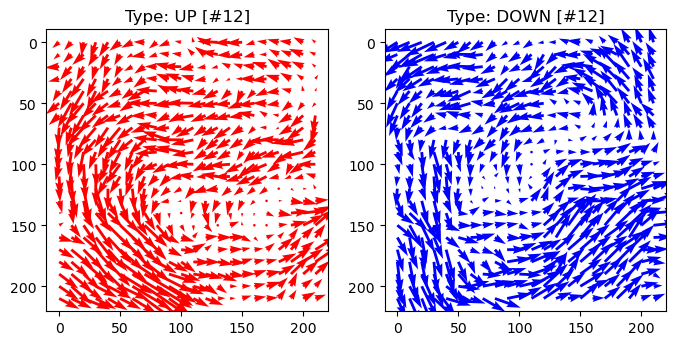

In [54]:
%matplotlib inline

from scipy.ndimage import rotate, gaussian_filter

def crop(img, center, width, height):
    ulx, uly = max(int(center[0] - width//2), 0), max(int(center[1] - height//2), 0)
    lrx, lry = min(int(center[0] + width//2), img.shape[1]), min(int(center[1] + height//2), img.shape[0])
    new_center = ((lrx-ulx)/2 , (lry-uly)/2)
    return img[uly:lry,ulx:lrx], new_center

def rotate_vector(vector, angle):
    '''rotate vectors'''
    x = vector[0] * np.cos(angle) - vector[1] * -np.sin(angle)
    y = vector[0] * -np.sin(angle) + vector[1] * np.cos(angle)
    return [x, y]    

def rotate_flow_field(flow, angle):
    '''rotate flow field'''
    uv_rot = rotate_vector(flow, angle)
    u = rotate(uv_rot[0], angle * 180/np.pi)
    v = rotate(uv_rot[1], angle * 180/np.pi)
    return [u, v]  

def defect_flow_frame_average(img1,img2, df_frame, defect_type="up", box=(300,300), filt=1):
    width, height = box[0], box[1]
    width1, height1 = int(width/2**.5), int(height/2**.5)
    flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    flow = gaussian_filter(flow, sigma=filt)

    if defect_type=="up":
        df = df_frame[df_frame.fuse_up].copy()
    elif defect_type=="down":
        df = df_frame[~df_frame.fuse_up].copy()   
    else:
        df = df_frame.copy()


    u_frame = np.zeros((height1, width1), dtype=np.float32)
    v_frame = u_frame
    count = 0

    x,y,th = ['xm', 'ym', 'angm1'] if defect_type=="minus" else ['xp', 'yp', 'angp1']

    for i in range(len(df[x])):
        try:
            # center at defect position
            cnt = (int(df[x].iloc[i]), int(df[y].iloc[i]))
            #1 crop each component of velocity field
            
            # image_crop = crop(255-img_clahe, cnt, width, height)[0] *** image
            u,_ = crop(flow[:,:,0], cnt, width, height)
            v,_ = crop(flow[:,:,1], cnt, width, height)

            #2 rotate velocity field (1. rotate vectors 2. rotate positions) 
            # image_rot = rotate(image_crop, df["angp1"].iloc[i] * 180/np.pi) *** image
            uv_rot = rotate_flow_field((u,v), df[th].iloc[i])

            #3 crop again to smaller box (box**0.5)
            cnt_crop = uv_rot[0].shape[1]/2, uv_rot[0].shape[0]/2
            # image_rot_crop = crop(image_rot, cnt_crop, width1, height1)[0] *** image
            u_frame = u_frame + crop(uv_rot[0], cnt_crop, width1, height1)[0]
            v_frame = v_frame + crop(uv_rot[1], cnt_crop, width1, height1)[0]
            count += 1 
        except:
            pass
        #      break

    if count:
        return u_frame/count, v_frame/count, count

image_list = glob.glob(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\*.tif")
image_list = natsorted(image_list, key=lambda y: y.lower())

frame = 51
img1 = cv2.imread(image_list[frame])[:,900:,0]
img2 = cv2.imread(image_list[frame+1])[:,900:,0] 
# df_frame = all_pairs_df[all_pairs_df.index == frame]
df_frame = all_pairs_df[all_pairs_df.index == frame]

u_up, v_up, count_up = defect_flow_frame_average(img1,img2, df_frame, defect_type="all")
u_dwn, v_dwn, up_dwn = defect_flow_frame_average(img1,img2, df_frame, defect_type="minus")
y, x = np.mgrid[0:u_up.shape[0], 0:u_up.shape[1]] 

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
step = 10
ax1.quiver(x[::step, ::step], y[::step, ::step], 
          u_up[::step, ::step], -v_up[::step, ::step],  color='r',
          width=.01, scale=10,)
ax1.set_title("Type: %1s [#%1d]" % ("UP", count_up))
ax1.set_box_aspect(1) ; ax1.invert_yaxis()

ax2.quiver(x[::step, ::step], y[::step, ::step], 
          u_dwn[::step, ::step], -v_dwn[::step, ::step],  color='b',
          width=.01, scale=10,)
# ax2.set_title(r"$\langle v \rangle _x =%.2f ~;~ \langle v \rangle _y =%.2f$" % (u_frame.mean(), v_frame.mean()))
ax2.set_title("Type: %1s [#%1d]" % ("DOWN", count_up))
ax2.set_box_aspect(1) ; ax2.invert_yaxis()


In [57]:
u_ups, v_ups, count_ups = [], [], []
u_dwns, v_dwns, count_dwns = [], [], []

all_frames = np.sort(all_pairs_df.index.unique().values)[1:200]

for frame in all_frames:
    img1 = cv2.imread(image_list[frame])[:,:,0] 
    img2 = cv2.imread(image_list[frame+1])[:,:,0]  
    df_frame = all_pairs_df[all_pairs_df.index == frame] #
    u_up, v_up, count_up = defect_flow_frame_average(img1,img2, df_frame, defect_type="all", filt=1)
    u_dwn, v_dwn, count_dwn = defect_flow_frame_average(img1,img2, df_frame, defect_type="minus", filt=1)

    u_ups.append(u_up)
    v_ups.append(v_up)
    count_ups.append(count_up)

    u_dwns.append(u_dwn)
    v_dwns.append(v_dwn)
    count_dwns.append(count_dwn)
    
    progressBar(frame, len(all_frames))

#     if frame % 5:
#         save_path = r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\av_flows\av_flows_create.pkl"

#         os.makedirs(os.path.dirname(save_path), exist_ok=True)
#         with open(save_path, 'wb') as f:
#                 pickle.dump(dict(u_ups=u_ups, v_ups=v_ups, count_ups=count_ups,
#                                 u_dwns=u_dwns , v_dwns=v_dwns , count_dwns=count_dwns                     
#                                 ), f)  

#     progressBar(frame, len(all_frames))


# save_path = r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\av_flows\av_flows_create.pkl"

# os.makedirs(os.path.dirname(save_path), exist_ok=True)
# with open(save_path, 'wb') as f:
#         pickle.dump(dict(u_ups=u_ups, v_ups=v_ups, count_ups=count_ups,
#                         u_dwns=u_dwns , v_dwns=v_dwns , count_dwns=count_dwns                     
#                         ), f)  

u_ups = np.array(u_ups)
v_ups = np.array(v_ups)
count_ups = np.array(count_ups)

u_dwns = np.array(u_dwns)
v_dwns = np.array(v_dwns)
count_dwns = np.array(count_dwns)

# # remove zero counts
# u_ups = np.array(u_ups)
# v_ups = np.array(v_ups)
# count_ups = np.array(count_ups)

# u_dwns = np.array(u_dwns)
# v_dwns = np.array(v_dwns)
# count_dwns = np.array(count_dwns)


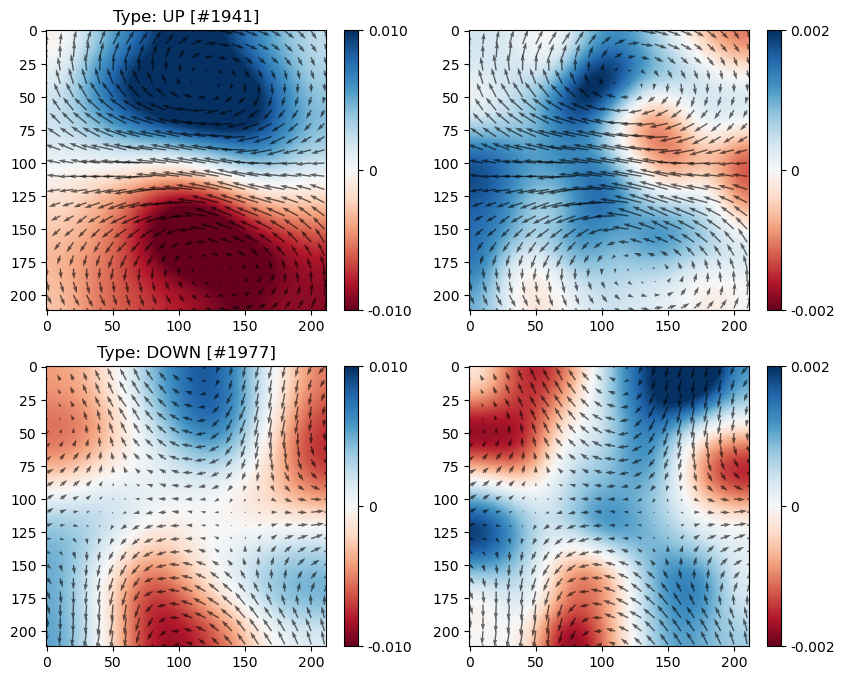

In [159]:
%matplotlib inline
filt = 20

u_up = np.average(u_ups[count_ups!= 0], axis=0, weights=count_ups[count_ups!= 0])
v_up = np.average(v_ups[count_ups!= 0], axis=0, weights=count_ups[count_ups!= 0])

u_dwn = np.average(u_dwns[count_dwns!= 0], axis=0, weights=count_dwns[count_dwns!= 0])
v_dwn = np.average(v_dwns[count_dwns!= 0], axis=0, weights=count_dwns[count_dwns!= 0])

y, x = np.mgrid[0:u_up.shape[0], 0:u_up.shape[1]] 

fig, axs = plt.subplots(2,2, figsize=(10,8))
ax1,ax2,ax3,ax4 = axs.ravel()
# fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
step = 10

field = np.stack((u_up, v_up), axis=-1)
vorticity = gaussian_filter(curl_npgrad(field), sigma=filt)
c1 = ax1.imshow(vorticity, cmap='RdBu', vmin=-.01, vmax=.01)
ax1.quiver(x[::step, ::step], y[::step, ::step], 
          u_up[::step, ::step], -v_up[::step, ::step],  color='k',
          width=.005, scale=5, alpha=.6)
ax1.set_title("Type: %1s [#%1d]" % ("UP", np.sum(count_ups)))

divergence = gaussian_filter(divergence_npgrad(field), sigma=filt)
c2 = ax2.imshow(divergence, cmap='RdBu', vmin=-.002, vmax=.002)
ax2.quiver(x[::step, ::step], y[::step, ::step], 
          u_up[::step, ::step], -v_up[::step, ::step],  color='k',
          width=.005, scale=5, alpha=.6)


field = np.stack((u_dwn, v_dwn), axis=-1)
vorticity = gaussian_filter(curl_npgrad(field), sigma=filt)
c3 = ax3.imshow(vorticity, cmap='RdBu', vmin=-.01, vmax=.01)
ax3.quiver(x[::step, ::step], y[::step, ::step], 
          u_dwn[::step, ::step], -v_dwn[::step, ::step],  color='k',
          width=.005, scale=5, alpha=.6)
ax3.set_title("Type: %1s [#%1d]" % ("DOWN", np.sum(count_dwns)))
      

divergence = gaussian_filter(divergence_npgrad(field), sigma=filt)
c4 = ax4.imshow(divergence, cmap='RdBu', vmin=-.002, vmax=.002)
ax4.quiver(x[::step, ::step], y[::step, ::step], 
          u_dwn[::step, ::step], -v_dwn[::step, ::step],  color='k',
          width=.005, scale=5, alpha=.6)
            

# ax2.set_title(r"$\langle v \rangle _x =%.2f ~;~ \langle v \rangle _y =%.2f$" % (u_frame.mean(), v_frame.mean()))

# Add colorbar, make sure to specify tick locations to match desired ticklabels
import matplotlib.ticker as mticker
ticks_vort, ticks_div = [-.01, 0, .01], [-.002, 0, .002]
for c,ticks in zip([c1,c2,c3,c4], [ticks_vort,ticks_div,ticks_vort,ticks_div]):
    fig.colorbar(c, ticks=ticks, format=mticker.FixedFormatter(("%.3f,%.0f,%.3f" % tuple(ticks)).split(',')))

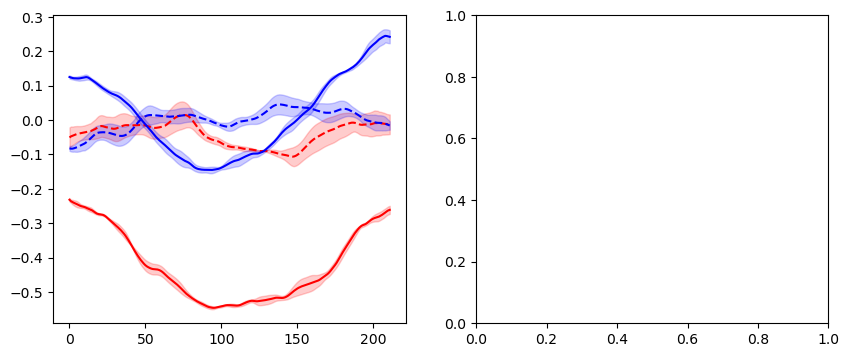

In [187]:
c = u_up.shape[0]//2
dc = 10

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
av  = u_up[c-dc:c+dc,:].mean(axis=0)
std  = u_up[c-dc:c+dc,:].std(axis=0)
xx = np.arange(len(av))
ax1.plot(xx, av, "-r")
ax1.fill_between(xx, av-std, av+std,  color="r", alpha=.2)

av  = v_up[c-dc:c+dc,:].mean(axis=0)
std  = v_up[c-dc:c+dc,:].std(axis=0)
xx = np.arange(len(av))
ax1.plot(xx, av, "--r")
ax1.fill_between(xx, av-std, av+std,  color="r", alpha=.2)


av  = u_dwn[c-dc:c+dc,:].mean(axis=0)
std  = u_dwn[c-dc:c+dc,:].std(axis=0)
xx = np.arange(len(av))
ax1.plot(xx, av, "-b")
ax1.fill_between(xx, av-std, av+std,  color="b", alpha=.2)

av  = v_dwn[c-dc:c+dc,:].mean(axis=0)
std  = v_dwn[c-dc:c+dc,:].std(axis=0)
xx = np.arange(len(av))
ax1.plot(xx, av, "--b")
ax1.fill_between(xx, av-std, av+std,  color="b", alpha=.2)

# av  = u_up[:,c-dc:c+dc].mean(axis=1)
# std  = u_up[:,c-dc:c+dc].std(axis=1)
# xx = np.arange(len(av))
# ax1.plot(xx, av, "--g")
# ax1.fill_between(xx, av-std, av+std,  color="g", alpha=.2)

# xx, av, std  = section(v_up[:,c-dc:c+dc], sec_axis="y")
# ax2.plot(xx, av, "--b")
# ax2.fill_between(xx, av-std, av+std,  color="b", alpha=.2)
# ax1.set_title(r"$v_x$"); ax1.set_ylabel(r"$average ~holrisontal ~velocity$"); ax1.set_box_aspect(1)

# xx, av, std  = section(u_dwn[:,c-dc:c+dc], sec_axis="y")
# ax1.plot(xx, av, "--g")
# ax1.fill_between(xx, av-std, av+std,  color="g", alpha=.2)
# xx, av, std  = section(v_dwn[:,c-dc:c+dc], sec_axis="y")
# ax2.plot(xx, av, "--g")
# ax2.fill_between(xx, av-std, av+std,  color="g", alpha=.2)
# ax2.set_title(r"$v_y$"); ax2.set_ylabel(r"$average ~vertical ~velocity$"); ax2.set_box_aspect(1)

In [170]:
u_up.shape[0]//2

106

# ------------ TRIES --------------------

            params     sigma
mu1       0.901669  0.003664
sigma1    0.193545  0.003874
A1      147.740700  2.081777
mu2       1.604523  0.005555
sigma2    0.208389  0.005988
A2      100.580279  2.021162


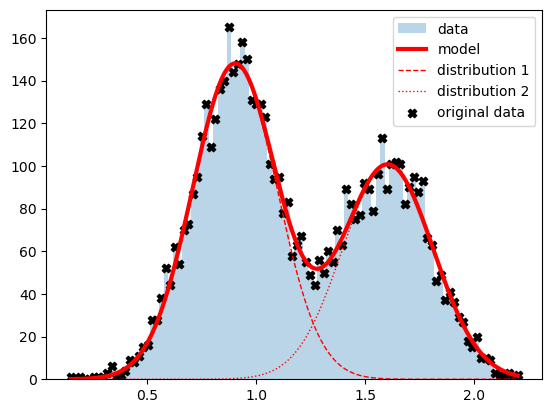

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

#data generation
np.random.seed(123)
data = np.concatenate((np.random.normal(.9, .2, 3500), np.random.normal(1.6, .2, 2500)))
y,x,_= plt.hist(data, 100, alpha=.3, label='data')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

#x, y inputs can be lists or 1D numpy arrays

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1) + gauss(x,mu2,sigma2,A2)

expected = (.8, .2, 250, 1.8, .2, 125)
params, cov = curve_fit(bimodal, x, y, expected)
sigma = np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
#plot combined...
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
#...and individual Gauss curves
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', lw=1, ls="--", label='distribution 1')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', lw=1, ls=":", label='distribution 2')
#and the original data points if no histogram has been created before
plt.scatter(x, y, marker="X", color="black", label="original data")
plt.legend()
print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.show() 

(0.9029628377210909, 0.0020159130483440495, 0.0005729815563985407)

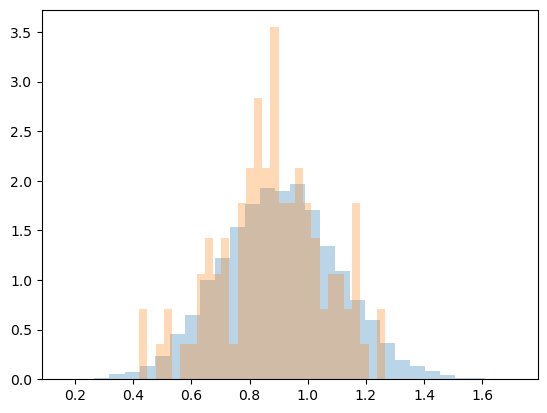

In [60]:
# import numpy as np
# from scipy.stats import sem
a = np.random.normal(.9, .2, 10000)
plt.hist(a, 30, alpha=.3, density=True)
plt.hist(a[:100], 30, alpha=.3, density=True)
# plt.plot(np.arange(len(a)), a, alpha=.3)
a.mean(), sem(a), sem(a[:100])/1000**.5